In [2]:
import torch
import sys
sys.path.append('../')
import matplotlib.pyplot as plt

In [198]:
import seaborn as sns

In [2]:
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import get_dist_info, init_dist

In [4]:
from mmcv import Config
from mmselfsup.datasets import build_dataset, build_dataloader
from mmselfsup.models import build_algorithm
from mmselfsup.core import build_optimizer

In [5]:
cfg = Config.fromfile("../configs/selfsup/swav_breast/swav_resnet18_avgpool_coslr-200e.py")

datasets = [build_dataset(cfg.data.train)]

In [6]:
from mmcv.runner import auto_fp16

In [8]:
data_loaders = [
        build_dataloader(
            ds,
            samples_per_gpu=3,
            workers_per_gpu=0,
            shuffle=False,
            # `num_gpus` will be ignored if distributed
            num_gpus=1,
            dist=True,
            replace=getattr(cfg.data, 'sampling_replace', False),
            seed=7,
            drop_last=getattr(cfg.data, 'drop_last', False),
            prefetch=False,
            persistent_workers=True,
            img_norm_cfg=getattr(cfg, 'img_norm_cfg', {}),
            breast=True,
        ) for ds in datasets
    ]

In [16]:
model = build_algorithm(cfg.model)
model.init_weights()
model = model.cuda()

2022-03-24 13:29:14,253 - mmcv - INFO - initialize ResNet with init_cfg [{'type': 'Kaiming', 'layer': 'Conv2d'}, {'type': 'Constant', 'val': 1, 'layer': ['_BatchNorm', 'GroupNorm']}]
2022-03-24 13:29:14,531 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name': 'norm2'}}
2022-03-24 13:29:14,535 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name': 'norm2'}}
2022-03-24 13:29:14,538 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name': 'norm2'}}
2022-03-24 13:29:14,540 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name': 'norm2'}}
2022-03-24 13:29:14,543 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name': 'norm2'}}
2022-03-24 13:29:14,584 - mmcv - INFO - initialize BasicBlock with init_cfg {'type': 'Constant', 'val': 0, 'override': {'name':

2022-03-24 13:29:14,910 - mmcv - INFO - 
ffdm_backbone.layer3.0.bn1.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of BreastSwAV  
 
2022-03-24 13:29:14,911 - mmcv - INFO - 
ffdm_backbone.layer3.0.conv2.weight - torch.Size([256, 256, 3, 3]): 
KaimingInit: a=0, mode=fan_out, nonlinearity=relu, distribution =normal, bias=0 
 
2022-03-24 13:29:14,911 - mmcv - INFO - 
ffdm_backbone.layer3.0.bn2.weight - torch.Size([256]): 
ConstantInit: val=0, bias=0 
 
2022-03-24 13:29:14,912 - mmcv - INFO - 
ffdm_backbone.layer3.0.bn2.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of BreastSwAV  
 
2022-03-24 13:29:14,912 - mmcv - INFO - 
ffdm_backbone.layer3.0.downsample.0.weight - torch.Size([256, 128, 1, 1]): 
KaimingInit: a=0, mode=fan_out, nonlinearity=relu, distribution =normal, bias=0 
 
2022-03-24 13:29:14,913 - mmcv - INFO - 
ffdm_backbone.layer3.0.downsample.1.weight - torch.Size([256]): 
The value is the same b

2022-03-24 13:29:14,935 - mmcv - INFO - 
us_backbone.layer2.0.bn2.weight - torch.Size([128]): 
ConstantInit: val=0, bias=0 
 
2022-03-24 13:29:14,936 - mmcv - INFO - 
us_backbone.layer2.0.bn2.bias - torch.Size([128]): 
The value is the same before and after calling `init_weights` of BreastSwAV  
 
2022-03-24 13:29:14,936 - mmcv - INFO - 
us_backbone.layer2.0.downsample.0.weight - torch.Size([128, 64, 1, 1]): 
KaimingInit: a=0, mode=fan_out, nonlinearity=relu, distribution =normal, bias=0 
 
2022-03-24 13:29:14,937 - mmcv - INFO - 
us_backbone.layer2.0.downsample.1.weight - torch.Size([128]): 
The value is the same before and after calling `init_weights` of BreastSwAV  
 
2022-03-24 13:29:14,937 - mmcv - INFO - 
us_backbone.layer2.0.downsample.1.bias - torch.Size([128]): 
The value is the same before and after calling `init_weights` of BreastSwAV  
 
2022-03-24 13:29:14,938 - mmcv - INFO - 
us_backbone.layer2.1.conv1.weight - torch.Size([128, 128, 3, 3]): 
KaimingInit: a=0, mode=fan_out

In [17]:

optimizer = build_optimizer(model, cfg.optimizer)

In [30]:
import os
if 'LOCAL_RANK' not in os.environ:
    os.environ['LOCAL_RANK'] = str(0)
    
if 'RANK' not in os.environ:
    os.environ['RANK'] = str(0)

In [31]:
os.environ['LOCAL_RANK']

'0'

In [9]:
# init_dist('pytorch', **cfg.dist_params)
# # re-set gpu_ids with distributed training mode
# _, world_size = get_dist_info()
# cfg.gpu_ids = range(world_size)

In [10]:
model = MMDistributedDataParallel(
            model if next(model.parameters()).is_cuda else model.cuda(),
            device_ids=[torch.cuda.current_device()],
            broadcast_buffers=False,
            find_unused_parameters=False)

NameError: name 'model' is not defined

In [11]:
for batch_ndx, sample in enumerate(data_loaders[0]):
    print(batch_ndx)
    break
#     sample['img_ffdm'] = sample['img_ffdm'].cuda()
#     sample['imgs_us'] = sample['imgs_us'].cuda()
#     loss = model(sample)
#     break

0


In [12]:
sample['img_ffdm'].shape

torch.Size([8, 3, 1472, 960])

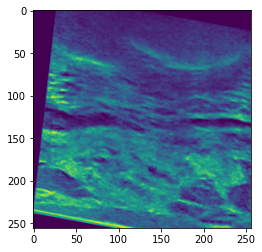

In [23]:
plt.imshow(sample['img'][1][0][0])

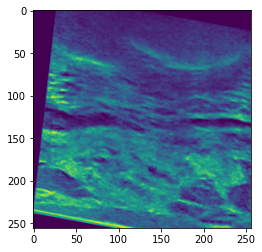

In [24]:
plt.imshow(sample['img'][1][0][1])

In [14]:
@auto_fp16(apply_to=('img', ))
def identity(img):
    return img

In [15]:
sample_ = identity(sample)

TypeError: @auto_fp16 can only be used to decorate the method of nn.Module

In [3]:
import numpy as np
import os
from PIL import Image

In [40]:
img_np = np.load('/gpfs/data/geraslab/Ashen/ultrasound_data/npy_img/17261404/2.npy')

img_np.shape

(438, 704, 3)

In [50]:
a = Image.fromarray(img_np[:, :, 0].astype("uint8")).convert('L')

In [51]:
np.array(a).shape

(438, 704)

In [26]:
data_loaders[0].dataset.data_source.data_infos[0]

{'episode_id': 15,
 'mrn': 4936,
 'study_date': datetime.date(2017, 4, 12),
 'biopsied': 0,
 'benign': 0,
 'malignant': 0,
 'us': {'img_prefix': '/gpfs/data/geraslab/Ashen/ultrasound_data/npy_img',
  'accession_number': '13085063',
  'indices': [1,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24],
  'filenames': ['1.2.840.113663.1500.1.423155361.3.30.20170412.154438.699',
   '1.2.840.113663.1500.1.423155361.3.27.20170412.154349.112',
   '1.2.840.113663.1500.1.423155361.3.23.20170412.154249.931',
   '1.2.840.113663.1500.1.423155361.3.14.20170412.154123.112',
   '1.2.840.113663.1500.1.423155361.3.13.20170412.154116.990',
   '1.2.840.113663.1500.1.423155361.3.10.20170412.154005.333',
   '1.2.840.113663.1500.1.423155361.3.11.20170412.154013.308',
   '1.2.840.113663.1500.1.423155361.3.12.20170412.154037.220',
   '1.2.840.113663.1500.1.423155361.3.15.20170412.154128.719',
   '1.2.840.113663.1500.1.423155361.

In [ ]:
import json
import pandas as pd

In [370]:
save_path = '/gpfs/data/geraslab/Nan/saves/selfsup/swav_breast/'
model_path = 'data_20220111_full/swav_resnet18_avgpool_coslr-100e_skynet-gpu32'
file = '20220328_151248.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_batch_64 = pd.DataFrame([json.loads(line) for line in lines])

model_path = 'data_20220111_full/swav_resnet18_avgpool_coslr-100e_largebatch_skynet-gpu32'
file = '20220330_115900.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_batch_128 = pd.DataFrame([json.loads(line) for line in lines])

model_path = 'data_20220111_full/swav_resnet18_avgpool_coslr-200e-ori_resolution_skynet'
file = "20220328_152803.log.json"
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_batch_32 = pd.DataFrame([json.loads(line) for line in lines])

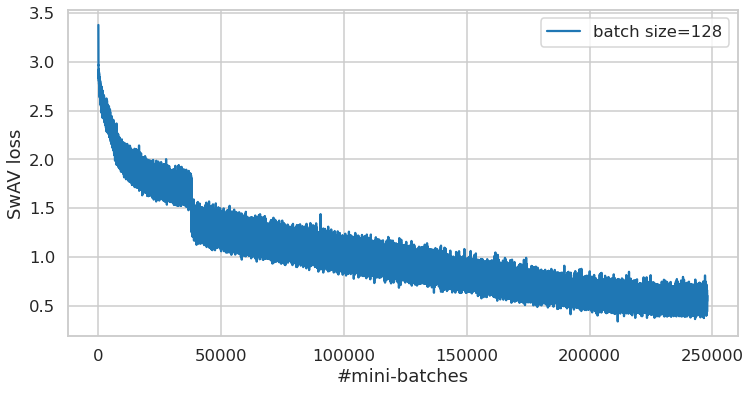

In [795]:
k = len(logs_batch_128)
plt.figure(figsize=(12, 6))
# logs_batch_32.loss.loc[:k].plot(label='batch size=32')
# logs_batch_64.loss.loc[:k].plot(label='batch size=64')
logs_batch_128.loss.loc[:k].plot(label='batch size=128')
plt.xlabel('#mini-batches')
plt.ylabel('SwAV loss')
plt.legend()

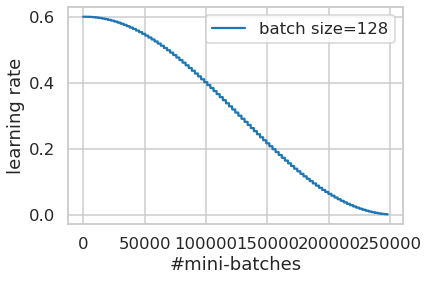

In [563]:
logs_batch_128.lr.plot(label='batch size=128')
plt.xlabel('#mini-batches')
plt.ylabel('learning rate')
plt.legend()

In [564]:
def plot_auc_learning_curve(logs, text):
    sns.set_context("talk")
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))
    logs[logs['mode']=='val']['head4_auc'].plot(marker='o', use_index=False, alpha=0.6)

    highest = logs[logs['mode']=='val']['head4_auc'].max()
    epoch = logs[logs['mode']=='val']['head4_auc'].argmax()

    plt.scatter(y=highest, x=epoch, marker='*', color='r', s=300)
    plt.text(y=highest-0.001, x=epoch-1, text=f'highest AUC={highest:1.3f}', s=100)

    plt.ylabel('Test AUC '+text)
    plt.xlabel('epoch')
    plt.plot()

In [565]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'
model_path = 'ffdm/ffdm_latest.pth'
file = '20220404_152308.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_batch_128_eval = pd.DataFrame([json.loads(line) for line in lines])

In [566]:
logs_batch_128_eval

,mode,epoch,iter,lr,memory,data_time,loss,acc,pos_size,neg_size,time,head4_auc,head4_acc
0,train,1,1,0.00001,4947.0,33.52513,0.70160,30.85938,17.50,46.50,40.92558,NaN,NaN
1,train,1,2,0.00001,4947.0,0.04013,0.69993,29.29688,16.50,47.50,0.31622,NaN,NaN
2,train,1,3,0.00001,4947.0,0.00239,0.69883,33.20312,19.50,44.50,0.09953,NaN,NaN
3,train,1,4,0.00001,4947.0,0.00212,0.70028,25.00000,15.00,49.00,10.07819,NaN,NaN
4,train,1,5,0.00001,4947.0,0.00299,0.70066,28.51562,17.50,46.50,0.10475,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,train,82,13,0.00000,4947.0,0.00170,0.63975,69.53125,19.50,44.50,0.09842,NaN,NaN
1390,train,82,14,0.00000,4947.0,0.01388,0.63507,70.70312,18.75,45.25,0.10992,NaN,NaN
1391,train,82,15,0.00000,4947.0,0.00172,0.61653,75.39062,15.75,48.25,0.09952,NaN,NaN
1392,train,82,16,0.00000,4947.0,0.00174,0.62208,75.00000,10.00,30.00,0.06812,NaN,NaN


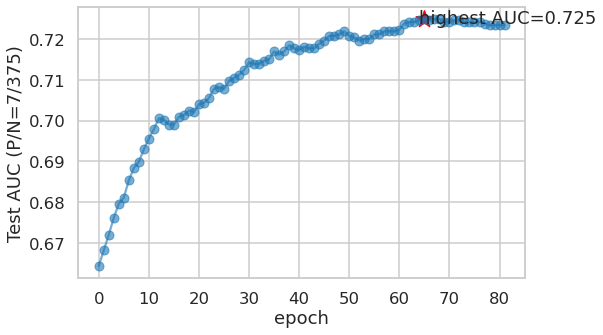

In [567]:
plot_auc_learning_curve(logs_batch_128_eval, '(P/N=7/375)')

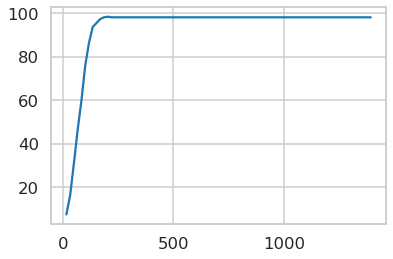

In [568]:
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_acc'].plot()

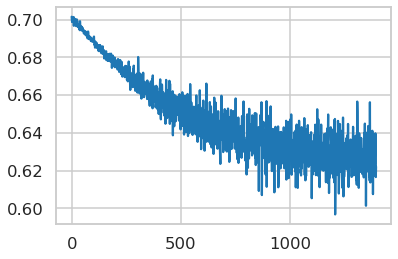

In [569]:
logs_batch_128_eval[logs_batch_128_eval['mode']=='train']['loss'].plot()

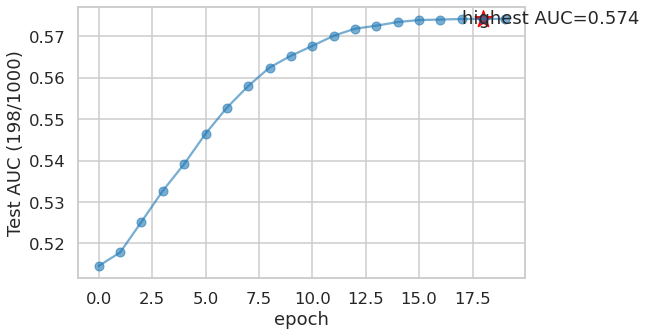

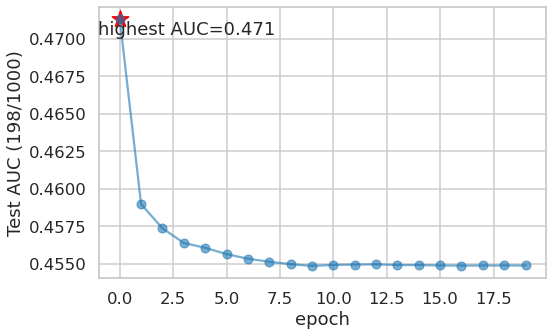

In [579]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'
model_path = 'ffdm/ffdm_latest.pth'
#file = 'unfreeze/20220407_154324.log.json'
file = 'balanced/20220405_144347.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_batch_128_eval = pd.DataFrame([json.loads(line) for line in lines])

plot_auc_learning_curve(logs_batch_128_eval, '(198/1000)')

#file = 'unfreeze_randominit/20220407_154748.log.json'
file = 'balanced_randominit/20220407_102959.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_random_eval = pd.DataFrame([json.loads(line) for line in lines])

plot_auc_learning_curve(logs_random_eval, '(198/1000)')

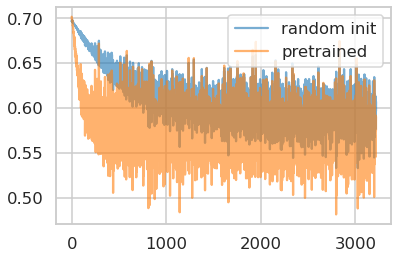

In [580]:
logs_random_eval[logs_random_eval['mode']=='train']['loss'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='train']['loss'][:len(logs_random_eval)].plot(alpha=0.6, label='pretrained')
plt.legend()

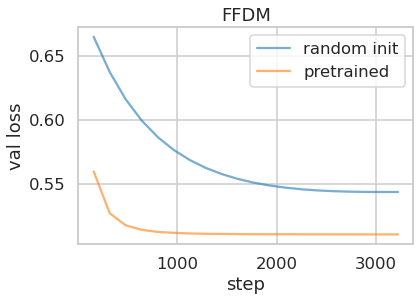

In [581]:
logs_random_eval[logs_random_eval['mode']=='val']['head4_loss'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_loss'][:len(logs_random_eval[logs_random_eval['mode']=='val'])].plot(
    alpha=0.6, label='pretrained'
)
plt.ylabel('val loss')
plt.xlabel('step')
plt.title('FFDM')
plt.legend()

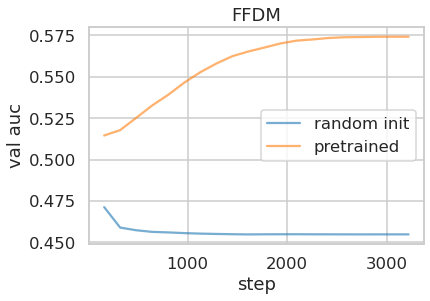

In [582]:
logs_random_eval[logs_random_eval['mode']=='val']['head4_auc'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_auc'][:len(logs_random_eval[logs_random_eval['mode']=='val'])].plot(
    alpha=0.6, label='pretrained'
)
plt.ylabel('val auc')
plt.xlabel('step')
plt.title('FFDM')
plt.legend()

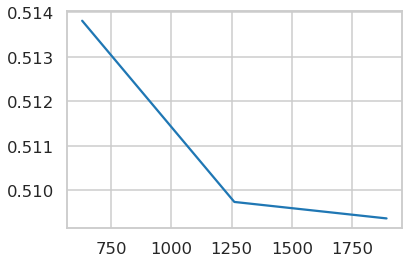

In [574]:
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_loss'].plot()

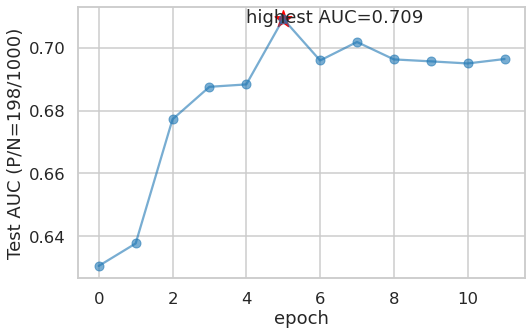

In [794]:
model_path = 'us/20220411_us_latest.pth'

file = 'unfreeze_batch8_imagenet_adamw/20220414_130853.log.json'
f = open(os.path.join(save_path, model_path, file))
lines = f.readlines()[1:]
logs_random_eval = pd.DataFrame([json.loads(line) for line in lines])

plot_auc_learning_curve(logs_random_eval, '(P/N=198/1000)')

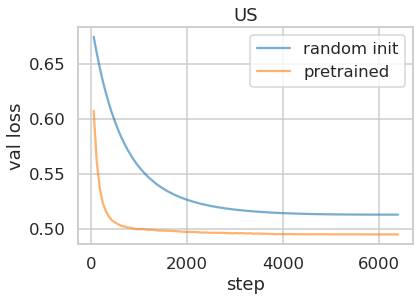

In [586]:
logs_random_eval[logs_random_eval['mode']=='val']['head4_loss'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_loss'][:len(logs_random_eval[logs_random_eval['mode']=='val'])].plot(
    alpha=0.6, label='pretrained'
)
plt.ylabel('val loss')
plt.xlabel('step')
plt.title('US')
plt.legend()

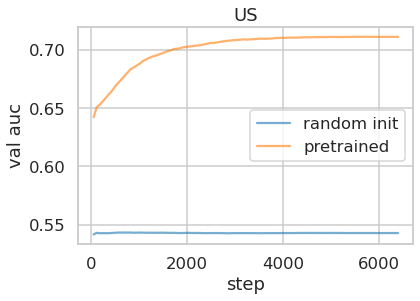

In [587]:
logs_random_eval[logs_random_eval['mode']=='val']['head4_auc'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='val']['head4_auc'][:len(logs_random_eval[logs_random_eval['mode']=='val'])].plot(
    alpha=0.6, label='pretrained'
)
plt.ylabel('val auc')
plt.xlabel('step')
plt.title('US')
plt.legend()

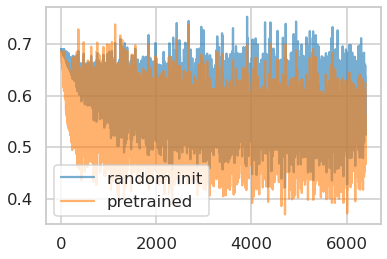

In [588]:
logs_random_eval[logs_random_eval['mode']=='train']['loss'].plot(alpha=0.6, label='random init')
logs_batch_128_eval[logs_batch_128_eval['mode']=='train']['loss'][:len(logs_random_eval)].plot(alpha=0.6, label='pretrained')
plt.legend()

In [781]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'ffdm/20220411_ffdm_latest.pth'

variants = ['unfreeze', 'unfreeze_imagenet', 'unfreeze_randominit']

performance = []
for cls in variants:
    file = sorted(glob.glob(os.path.join(save_path, model_path, cls, '*.json')))[-1]
    
    f = open(file)
    lines = f.readlines()[1:]
    logs = pd.DataFrame([json.loads(line) for line in lines])
    
    print(file,'epoch' ,logs.epoch.max())
    if logs.epoch.max()>20:
    
        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()
        performance.append({'model': cls, 'loss': loss, 'auc': auc})
performance = pd.DataFrame(performance)

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze/20220412_215058.log.json epoch 200
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze_imagenet/20220413_134835.log.json epoch 200
/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/ffdm/20220411_ffdm_latest.pth/unfreeze_randominit/20220412_215240.log.json epoch 200


In [782]:
performance

,model,loss,auc
0,unfreeze,0.50802,0.59044
1,unfreeze_imagenet,0.51468,0.56937
2,unfreeze_randominit,0.50810,0.55345


In [756]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'

#variants = ['balanced', 'balanced_imagenet', 'balanced_randominit']
variants = ['unfreeze_batch16']#, 'unfreeze_batch16_imagenet', 'unfreeze_batch16_randominit']


performance = []
for cls in variants:
    file = sorted(glob.glob(os.path.join(save_path, model_path, cls, '*.json')))[-1]
    
    f = open(file)
    lines = f.readlines()[1:]
    logs = pd.DataFrame([json.loads(line) for line in lines])
    
    print(file,'epoch' ,logs.epoch.max())
    if logs.epoch.max()>20:
    
        loss, auc = logs[logs['mode']=='val'].head4_loss.min(), logs[logs['mode']=='val'].head4_auc.max()
        performance.append({'model': cls, 'loss': loss, 'auc': auc})
performance = pd.DataFrame(performance)

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16/20220412_214906.log.json epoch 100


In [757]:
logs

,mode,epoch,iter,lr,memory,data_time,loss,acc,pos_size,neg_size,time,head4_loss,head4_auc,head4_acc
0,train,1,1,0.0001,4013.0,5.48122,0.68748,56.25,4.0,12.0,12.02525,NaN,NaN,NaN
1,train,1,2,0.0001,5182.0,0.04394,0.68663,75.00,3.0,13.0,0.90909,NaN,NaN,NaN
2,train,1,3,0.0001,5182.0,0.00136,0.68115,81.25,2.0,14.0,0.71432,NaN,NaN,NaN
3,train,1,4,0.0001,5182.0,0.00190,0.67713,87.50,3.0,13.0,0.80688,NaN,NaN,NaN
4,train,1,5,0.0001,5935.0,0.00187,0.68030,75.00,5.0,11.0,1.00949,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25095,train,100,247,0.0000,8672.0,0.27843,0.41596,75.00,3.0,13.0,0.35087,NaN,NaN,NaN
25096,train,100,248,0.0000,8672.0,0.09244,0.34545,93.75,1.0,15.0,0.15258,NaN,NaN,NaN
25097,train,100,249,0.0000,8672.0,0.06891,0.67395,62.50,7.0,9.0,0.13343,NaN,NaN,NaN
25098,train,100,250,0.0000,8672.0,0.07808,0.52666,68.75,4.0,12.0,0.14018,NaN,NaN,NaN


In [792]:
def learning_curves(save_path, model_path, prefix, title, imagenet_suffix=''): 
    file = sorted(glob.glob(os.path.join(save_path, model_path, prefix, '*.json')))[-1]  
    print(file)
    f = open(file)
    lines = f.readlines()[1:]
    logs_swav = pd.DataFrame([json.loads(line) for line in lines])


    file = sorted(glob.glob(os.path.join(save_path, model_path, prefix+'_imagenet'+imagenet_suffix, '*.json')))[-1]  
    f = open(file)
    lines = f.readlines()[1:]
    logs_imagenet = pd.DataFrame([json.loads(line) for line in lines])

    file = sorted(glob.glob(os.path.join(save_path, model_path, prefix+'_randominit', '*.json')))[-1]  
    f = open(file)
    lines = f.readlines()[1:]
    logs_random = pd.DataFrame([json.loads(line) for line in lines])

    fig, axs = plt.subplots(1, 3, figsize=(20, 4))

    if 'FFDM' not in title and len(logs_imagenet)!=len(logs_swav):
        step = 2
    else:
        step = 1
    logs_imagenet[logs_imagenet['mode']=='train'].loss.rolling(50).mean().iloc[::step].plot(
        use_index=False, label='Imagenet', ax=axs[0], alpha=0.5)
    logs_swav[logs_swav['mode']=='train'].loss.rolling(50).mean().plot(
        use_index=False, label='cross-modal SwAV', ax=axs[0], alpha=0.5)
    logs_random[logs_random['mode']=='train'].loss.rolling(50).mean().plot(
        use_index=False, label='random init', ax=axs[0], alpha=0.5)
    axs[0].set_ylabel('train loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()

    logs_imagenet[logs_imagenet['mode']=='val'].head4_loss.plot(use_index=False, label='Imagenet', ax=axs[1])
    logs_swav[logs_swav['mode']=='val'].head4_loss.plot(use_index=False, label='cross-modal SwAV', ax=axs[1])
    logs_random[logs_random['mode']=='val'].head4_loss.plot(use_index=False, label='random init', ax=axs[1])
    axs[1].set_ylabel('val loss')
    axs[1].set_xlabel('epoch')
    axs[1].legend()


    logs_imagenet[logs_imagenet['mode']=='val'].head4_auc.plot(use_index=False, label='Imagenet', ax=axs[2])
    logs_swav[logs_swav['mode']=='val'].head4_auc.plot(use_index=False, label='cross-modal SwAV', ax=axs[2])
    logs_random[logs_random['mode']=='val'].head4_auc.plot(use_index=False, label='random init', ax=axs[2])
    axs[2].set_ylabel('val auc')
    axs[2].set_xlabel('epoch')
    axs[2].legend()

    axs[0].set_title(title)
    axs[1].set_title(title)
    axs[2].set_title(title)
    plt.show()

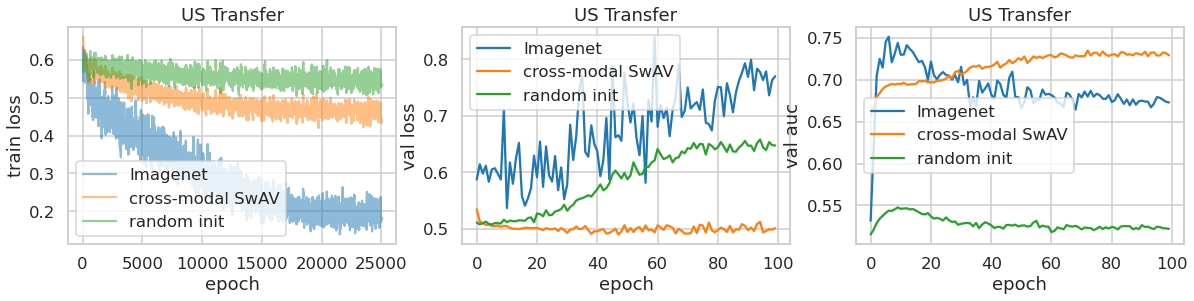

In [788]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'
prefix = 'unfreeze_batch16'

learning_curves(save_path, model_path, prefix, 'US Transfer', '')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/unfreeze_batch16_lr1e3/20220413_162308.log.json


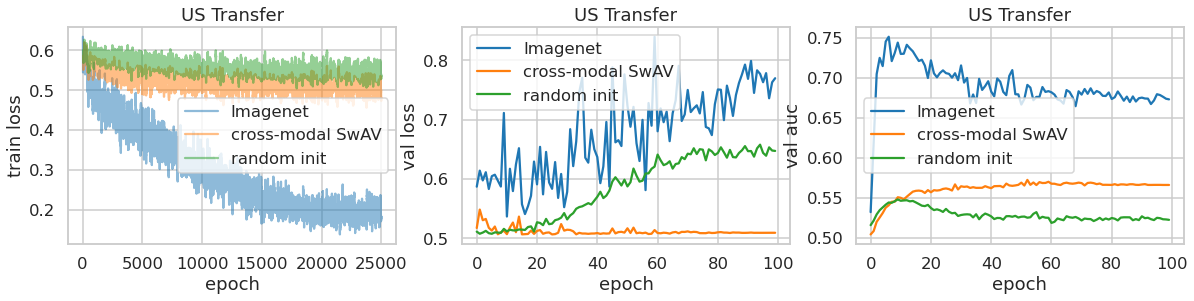

In [790]:

learning_curves(save_path, model_path, prefix, 'US Transfer', '')

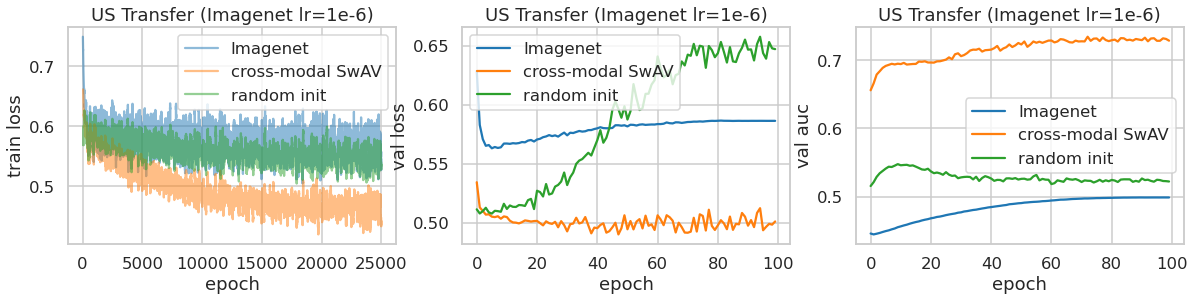

In [778]:
learning_curves(save_path, model_path, prefix, 'US Transfer (Imagenet lr=1e-6)', '_lr1e6')

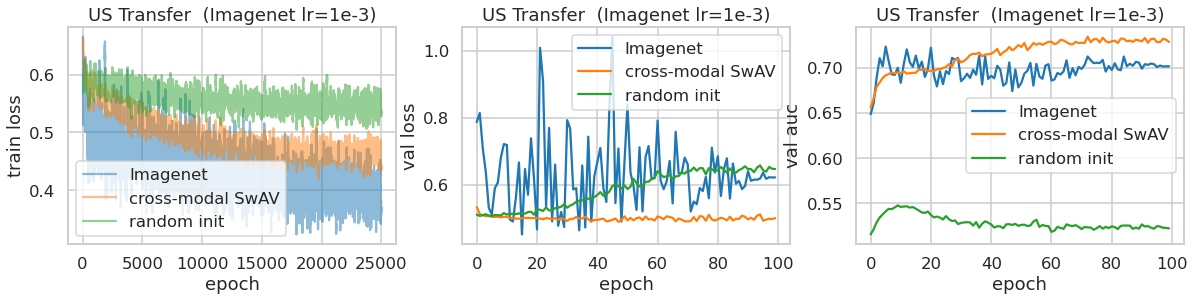

In [779]:
learning_curves(save_path, model_path, prefix, 'US Transfer  (Imagenet lr=1e-3)', '_lr1e3')

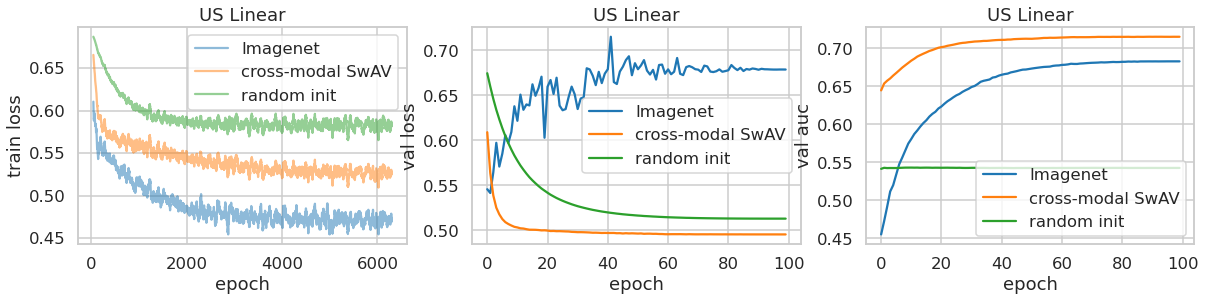

In [740]:
prefix = 'balanced'
learning_curves(save_path, model_path, prefix, 'US Linear')

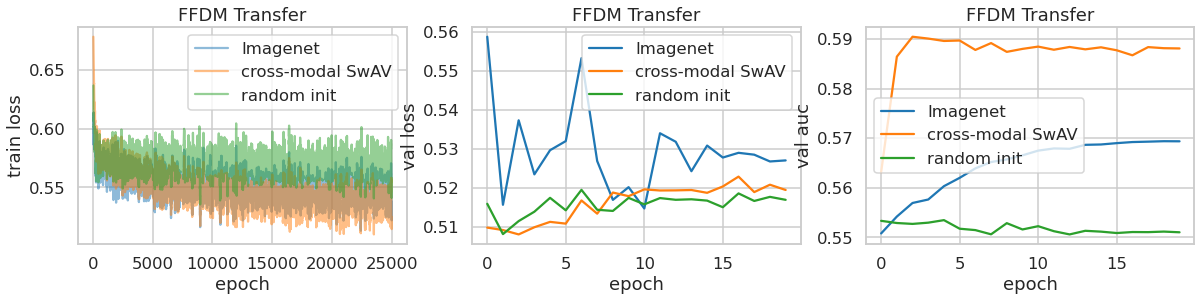

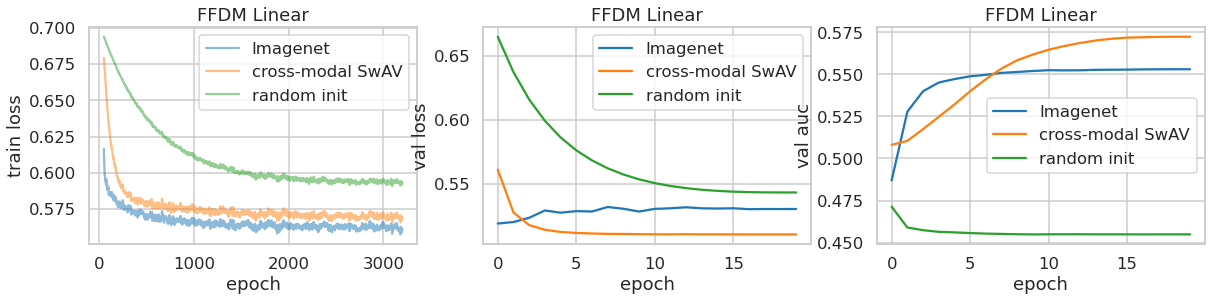

In [780]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'ffdm/20220411_ffdm_latest.pth'
prefix = 'unfreeze'

learning_curves(save_path, model_path, prefix, 'FFDM Transfer')

prefix = 'balanced'

learning_curves(save_path, model_path, prefix, 'FFDM Linear')

/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/us/20220411_us_latest.pth/balanced/20220412_130853.log.json


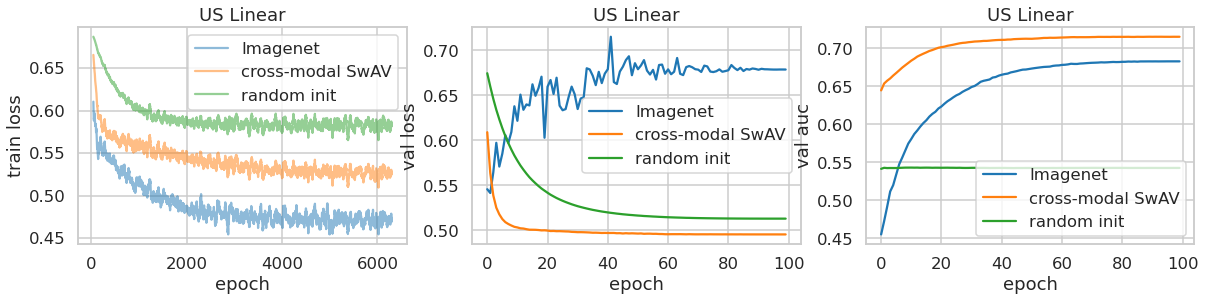

In [793]:
save_path = '/gpfs/data/geraslab/Nan/mmselfsup/work_dirs/benchmarks/classification/nyubreast/'

model_path = 'us/20220411_us_latest.pth'

prefix = 'balanced'

learning_curves(save_path, model_path, prefix, 'US Linear')